In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image 
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [2]:
loan_result = pd.read_csv('data/loan_result.csv')
# log_data = pd.read_csv('data/log_Data.csv')
user_spec = pd.read_csv('data/user_spec.csv')

In [3]:
loan_result.columns=['신청서_번호', '한도조회_일시', '금융사_번호', '상품_번호', '승인한도', '승인금리', '신청_여부(y)']
# log_data.columns=['유저_번호', '행동명', '행동일시', '운영체제', '앱_버전', '일_코드']
user_spec.columns=['신청서_번호', '유저_번호', '유저_생년월일', '유저_성별', '생성일시', '한도조회_당시_유저_신용점수', '연소득', '근로형태', '입사연월', '고용형태', '주거소유형태', '대출희망금액', '대출_목적', '개인회생자_여부', '개인회생자_납입_완료_여부', '기대출수', '기대출금액'] # 건강보험 타입이 정의서에는 있는데 데이터엔 없는듯
 

## user_spec.csv

In [4]:
user_spec.sort_values(by = '생성일시',ascending = True,inplace = True)# 날짜순서로 sort
user_spec.reset_index(drop = True,inplace = True)

user_spec에는 있지만 loan_result에 없는경우: 삭제

In [5]:
drop_list = list(set(user_spec['신청서_번호'])-set(loan_result['신청서_번호']))
user_spec.drop(user_spec[user_spec['신청서_번호'].isin(drop_list)].index,inplace=True)
user_spec.reset_index(drop = True,inplace = True)

loan_result에 있지만 user_spec에 없는 신청서_번호
- 모두 신청이 된 상품
- 승인한도, 승인금리가 없음

user_spec과 mapping이 안되므로 drop

In [6]:
index_list = loan_result[loan_result['신청서_번호'].isin(list(set(loan_result['신청서_번호'].unique())-set(user_spec['신청서_번호'])))].index

In [7]:
loan_result.drop(index_list,inplace = True)
loan_result.reset_index(drop = True,inplace=True)

## 유저_번호 전처리
- 각 유저들이 몇번을 신용조회를 통해 대출비교를 했는지 count하여 파생변수 만들기

In [8]:
user_spec['대출비교횟수'] = user_spec.groupby('유저_번호')['유저_번호'].transform('count')

## 유저_생년월일&유저_성별 전처리
- 2004년부터 2008년까지 유저들(114명)이 loan_result에서 겹치는 유저가 있었는데 loan_result에 해당이 되지 않아 모두 삭제됨
- 유저 생년월일과 null인 데이터는 유저 성별도 null값이다.(8593개) 논의

In [9]:
# #생년월일이 없는 12961명 중에 4368명은 loan_result에서 신청서 번호가 없다 -> 이들은 대출 신청을 하지 않은 유저들이기 때문에 data 삭제
# app_list = user_spec[user_spec['유저_생년월일'].isnull()]['신청서_번호']
# temp = list(loan_result['신청서_번호'])
# len(set(app_list)-(set(app_list)&set(temp)))
# a = list(set(app_list)-(set(app_list)&set(temp)))
# user_spec = user_spec.drop(user_spec[user_spec['신청서_번호'].isin(a)].index)

In [10]:
loan_result[loan_result['신청서_번호'].isin(list(user_spec[(user_spec['유저_생년월일'].isnull())]['신청서_번호']))]# 생년월일과 성별이 없는 유저들의 loan_result

,신청서_번호,한도조회_일시,금융사_번호,상품_번호,승인한도,승인금리,신청_여부(y)
318,107628,2022-06-07 23:38:26,38,223,3000000.0,7.4,NaN
319,107628,2022-06-07 23:38:27,25,163,3000000.0,11.9,NaN
320,107628,2022-06-07 23:38:27,21,196,3000000.0,8.6,NaN
321,107628,2022-06-07 23:38:26,42,258,3000000.0,9.1,NaN
322,107628,2022-06-07 23:38:26,44,8,3000000.0,9.8,NaN
...,...,...,...,...,...,...,...
13525970,191834,2022-06-03 14:20:53,35,29,2000000.0,19.4,NaN
13525971,191834,2022-06-03 14:20:42,59,150,22000000.0,16.4,NaN
13525972,191834,2022-06-03 14:20:43,35,168,13000000.0,19.4,NaN
13525973,191834,2022-06-03 14:20:44,58,175,16000000.0,13.8,NaN


## 한도조회_당시_유저_신용점수 전처리
- 25%는 신용점수가 없음
- 신용점수등급에 따라 점수대를 구분한다.
- 신용점수가 없는 유저들은 0점으로 대체
    - 신용점수 대체를 어떻게 할것인가 논의
    - 신용점수가 소득보다 대출금상환, 신용카드와 관련된 항목 -> 기대출수, 기대출금액상환
    - 신용점수등급과 연소득은 비례 -> 연소득

In [11]:
user_spec.loc[user_spec['한도조회_당시_유저_신용점수'].isnull(),'한도조회_당시_유저_신용점수'] = 0

In [12]:
bins = [-2, 0, 444, 514, 599, 664, 749, 804, 839, 869, 899, 1000]
labels = ['null', '10등급', '9등급', '8등급', '7등급', '6등급', '5등급', '4등급', '3등급', '2등급', '1등급']
user_spec['신용점수등급'] = pd.cut(user_spec['한도조회_당시_유저_신용점수'],bins = bins, labels = labels)
user_spec.loc[user_spec['한도조회_당시_유저_신용점수'].isnull(),'한도조회_당시_유저_신용점수'] = 0

In [13]:
user_spec['연소득'].mean()

44860091.1275538

<AxesSubplot:xlabel='신용점수등급'>

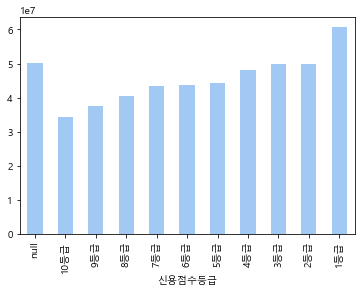

In [14]:
sns.set_palette("pastel")
user_spec.groupby(['신용점수등급'])['연소득'].mean().plot.bar()

## 입사연월 전처리
- 입사년차 계산하여 column 생성
    - 입사연월이 없는 경우 -1로 처리
- 입사연월이 null인 경우는 모두 기타수입이나 사업자 논의

In [15]:
user_spec[user_spec['입사연월'].isnull()]['근로형태'].value_counts()

OTHERINCOME        92307
EARNEDINCOME           4
PRIVATEBUSINESS        3
Name: 근로형태, dtype: int64

In [16]:
user_spec[(user_spec['입사연월'].isnull())&(user_spec['근로형태']=='EARNEDINCOME')]# 퇴사?

,신청서_번호,유저_번호,유저_생년월일,유저_성별,생성일시,한도조회_당시_유저_신용점수,연소득,근로형태,입사연월,고용형태,주거소유형태,대출희망금액,대출_목적,개인회생자_여부,개인회생자_납입_완료_여부,기대출수,기대출금액,대출비교횟수,신용점수등급
297051,1026844,174784,1998.0,1.0,2022-04-08 15:12:08,0.0,32000000.0,EARNEDINCOME,NaN,정규직,전월세,10000000.0,SWITCHLOAN,NaN,NaN,NaN,NaN,1,null
485984,860275,861913,1980.0,0.0,2022-05-02 16:19:56,0.0,21000000.0,EARNEDINCOME,NaN,정규직,전월세,20000000.0,LIVING,NaN,NaN,NaN,NaN,1,null
584555,1401966,776609,1991.0,0.0,2022-05-13 23:15:27,930.0,26000000.0,EARNEDINCOME,NaN,계약직,전월세,10000000.0,생활비,0.0,0.0,1.0,NaN,2,1등급
742447,89051,776609,1991.0,0.0,2022-06-02 19:28:01,800.0,2000000.0,EARNEDINCOME,NaN,계약직,전월세,10000000.0,생활비,0.0,0.0,1.0,NaN,2,5등급


In [17]:
user_spec[(user_spec['입사연월'].isnull())&(user_spec['근로형태']=='PRIVATEBUSINESS')]# 사업자는 입사연월을 추정하기 어려움

,신청서_번호,유저_번호,유저_생년월일,유저_성별,생성일시,한도조회_당시_유저_신용점수,연소득,근로형태,입사연월,고용형태,주거소유형태,대출희망금액,대출_목적,개인회생자_여부,개인회생자_납입_완료_여부,기대출수,기대출금액,대출비교횟수,신용점수등급
348538,978338,418233,1985.0,0.0,2022-04-14 18:52:19,690.0,50000000.0,PRIVATEBUSINESS,NaN,기타,전월세,30000000.0,사업자금,NaN,NaN,3.0,20000000.0,3,6등급
592526,478904,418233,1985.0,0.0,2022-05-15 17:40:59,690.0,50000000.0,PRIVATEBUSINESS,NaN,기타,전월세,20000000.0,생활비,0.0,0.0,3.0,20000000.0,3,6등급
601944,1024494,418233,1985.0,0.0,2022-05-16 15:28:53,690.0,50000000.0,PRIVATEBUSINESS,NaN,기타,전월세,50000000.0,사업자금,0.0,0.0,3.0,20000000.0,3,6등급


7명의 입사연월을 각 유저의 생년월일, 성별, 고용형태와 동일한 유저들의 입사연월 중 최빈값으로 대체


In [18]:
user_list = list(user_spec[(user_spec['입사연월'].isnull())&(user_spec['근로형태']=='EARNEDINCOME')]['유저_번호'].index)+list(user_spec[(user_spec['입사연월'].isnull())&(user_spec['근로형태']=='PRIVATEBUSINESS')]['유저_번호'].index)
for i in user_list:
    user_spec.iloc[i,8] = user_spec[(user_spec['유저_생년월일']==user_spec.iloc[i,2])&(user_spec['유저_성별']==user_spec.iloc[i,3])&(user_spec['고용형태']==user_spec.iloc[i,9])]['입사연월'].mode()[0]

In [19]:
#생성일시 datetime으로 변경
user_spec['생성일시_연월'] = user_spec['생성일시'].str[:7]
user_spec['생성일시_연월'] = user_spec['생성일시_연월'].str.replace(pat=r'[^\w]', repl=r'', regex=True)
user_spec['생성일시_연월'] = pd.to_datetime(user_spec['생성일시_연월'],format = '%Y%m')

In [20]:
#입사연월 datetime으로 변경
user_spec['입사연월_연월'] = user_spec['입사연월'].astype(str).str[:6]
user_spec.loc[user_spec['입사연월_연월']=='nan','입사연월_연월'] = '202301'# nan값인 데이터들 처리
user_spec['입사연월_연월'] = pd.to_datetime(user_spec['입사연월_연월'],format = '%Y%m')

In [21]:
from datetime import datetime
def diff_month(x): # 입사년차 계산 함수
    return (x[0].year - x[1].year) * 12 + x[0].month - x[1].month 

In [22]:
user_spec['입사개월'] = user_spec[['생성일시_연월', '입사연월_연월']].apply(diff_month,axis =1)
user_spec.loc[user_spec['입사개월']<0,'입사개월'] = '-1'
user_spec['입사개월'] = user_spec['입사개월'].astype(int)

입사년도가 유저의 생년월일보다 빠른 데이터& 입사년차가 이상한 데이터 는 수정 필요....

In [23]:
user_spec['유저_생년월일'] = pd.to_datetime(user_spec['유저_생년월일'],format = '%Y') #유저 생년월일 datetime으로 변경
user_spec[user_spec['유저_생년월일']>user_spec['입사연월_연월']]

,신청서_번호,유저_번호,유저_생년월일,유저_성별,생성일시,한도조회_당시_유저_신용점수,연소득,근로형태,입사연월,고용형태,...,대출_목적,개인회생자_여부,개인회생자_납입_완료_여부,기대출수,기대출금액,대출비교횟수,신용점수등급,생성일시_연월,입사연월_연월,입사개월
95321,2110731,315682,1987-01-01,1.0,2022-03-14 13:54:41,850.0,49000000.0,PRIVATEBUSINESS,196909.0,정규직,...,생활비,NaN,NaN,NaN,NaN,1,3등급,2022-03-01,1969-09-01,630
165079,1017715,510729,1996-01-01,0.0,2022-03-22 21:56:04,760.0,24000000.0,EARNEDINCOME,198909.0,정규직,...,생활비,NaN,NaN,NaN,NaN,4,5등급,2022-03-01,1989-09-01,390
182339,134985,422485,1980-01-01,1.0,2022-03-24 21:40:28,670.0,7000000.0,PRIVATEBUSINESS,197905.0,정규직,...,생활비,NaN,NaN,6.0,128000000.0,2,6등급,2022-03-01,1979-05-01,514
266924,89768,697649,1996-01-01,1.0,2022-04-05 14:08:47,540.0,30000000.0,PRIVATEBUSINESS,199401.0,정규직,...,대환대출,NaN,NaN,NaN,NaN,1,8등급,2022-04-01,1994-01-01,339
335713,724683,27284,1957-01-01,1.0,2022-04-13 13:02:03,520.0,45000000.0,EARNEDINCOME,191601.0,정규직,...,LIVING,NaN,NaN,4.0,79000000.0,1,8등급,2022-04-01,1916-01-01,1275
369701,455095,652264,1981-01-01,1.0,2022-04-18 10:23:41,650.0,54000000.0,PRIVATEBUSINESS,197705.0,정규직,...,사업자금,NaN,NaN,5.0,30000000.0,8,7등급,2022-04-01,1977-05-01,539
389853,1709019,652264,1981-01-01,1.0,2022-04-20 10:16:25,650.0,54000000.0,PRIVATEBUSINESS,197705.0,정규직,...,사업자금,0.0,NaN,5.0,30000000.0,8,7등급,2022-04-01,1977-05-01,539
396652,1755828,166829,1961-01-01,1.0,2022-04-20 23:02:50,650.0,40000000.0,EARNEDINCOME,192008.0,정규직,...,LIVING,NaN,NaN,5.0,35000000.0,3,7등급,2022-04-01,1920-08-01,1220
398815,1135212,652264,1981-01-01,1.0,2022-04-21 09:54:20,650.0,54000000.0,PRIVATEBUSINESS,197705.0,정규직,...,사업자금,0.0,NaN,5.0,30000000.0,8,7등급,2022-04-01,1977-05-01,539
401927,1121346,719066,2002-01-01,0.0,2022-04-21 14:21:24,740.0,1000000.0,EARNEDINCOME2,200008.0,기타,...,HOUSEDEPOSIT,NaN,NaN,1.0,3000000.0,1,6등급,2022-04-01,2000-08-01,260


In [24]:
user_spec['고용형태'].value_counts()

정규직    670268
기타     198756
계약직     84945
일용직     14784
Name: 고용형태, dtype: int64

## 연소득 전처리
1명이 해당되는데 기대출수가 있고 사업자금이 목적인 사람들의 평균 연소득으로 대체

In [27]:
no_duplicated_user = user_spec.drop_duplicates(['유저_번호'])
no_duplicated_user[(no_duplicated_user['대출_목적']=='사업자금')&(no_duplicated_user['기대출수']>0)]['연소득'].mean()

67936439.68415292

In [28]:
user_spec.loc[user_spec[user_spec['연소득'].isnull()].index,'연소득']=6800

In [29]:
user_spec.reset_index(drop =True,inplace = True)

In [30]:
user_spec.isnull().sum()

신청서_번호                  0
유저_번호                   0
유저_생년월일              8593
유저_성별                8593
생성일시                    0
한도조회_당시_유저_신용점수         0
연소득                     0
근로형태                    0
입사연월                92307
고용형태                    0
주거소유형태                  0
대출희망금액                  0
대출_목적                   0
개인회생자_여부           417763
개인회생자_납입_완료_여부     843993
기대출수               146290
기대출금액              225046
대출비교횟수                  0
신용점수등급                  0
생성일시_연월                 0
입사연월_연월                 0
입사개월                    0
dtype: int64

## 개인회생자_여부,개인회생자_납입_완료_여부 전처리

In [ ]:
user_spec['개인회생자_납입_완료_여부'].value_counts()

In [ ]:
user_spec[user_spec['개인회생자_납입_완료_여부'].isnull()]['신용점수등급'].value_counts()

## 기대출수, 기대출금액 전처리

In [ ]:
user_spec['기대출금액'].describe()